# Loading pre-processed dataset

In [1]:
import pandas as pd

# Load the preprocessed, scaled dataset (without labels)
file_path = "../../data/processed/clustering_preprocessing_robust_scaled.csv"
df = pd.read_csv(file_path)

# Preview the data
print(df.shape)
df.head()


(2078, 19)


Gender       Age    Height    Weight  family_history_with_overweight  FAVC  \
0    -1.0 -0.305183 -0.587756 -0.458016                             0.0  -1.0   
1    -1.0 -0.305183 -1.306126 -0.648137                             0.0  -1.0   
2     0.0  0.023948  0.705310 -0.149071                             0.0  -1.0   
3     0.0  0.682209  0.705310  0.088580                            -1.0  -1.0   
4     0.0 -0.140618  0.561636  0.155122                            -1.0  -1.0   

      FCVC       NCP  CAEC  SMOKE      CH2O  SCC       FAF       TUE  CALC  \
0 -0.39728  0.000000   0.0    0.0  0.000000  0.0 -0.644237  0.369134  -1.0   
1  0.60272  0.000000   0.0    1.0  1.139397  1.0  1.288474 -0.630866   0.0   
2 -0.39728  0.000000   0.0    0.0  0.000000  0.0  0.644237  0.369134   1.0   
3  0.60272  0.000000   0.0    0.0  0.000000  0.0  0.644237 -0.630866   1.0   
4 -0.39728 -6.725583   0.0    0.0  0.000000  0.0 -0.644237 -0.630866   0.0   

   MTRANS_Bike  MTRANS_Motorbike  MTRANS_Public_Transportation  MTRANS_Walking  
0          0.0               0.0                           0.0             0.0  
1          0.0               0.0                           0.0             0.0  
2          0.0               0.0                           0.0             0.0  
3          0.0               0.0                          -1.0             1.0  
4          0.0               0.0                           0.0             0.0

### Finding the best number of clusters to be used

In [41]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

silhouette_scores = []

# Try k from 2 to 10
for k in range(2, 11):
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(df)
    score = silhouette_score(df, labels)
    silhouette_scores.append((k, score))
    print(f"Clusters: {k}, Silhouette Score: {score:.4f}")


Clusters: 2, Silhouette Score: 0.4908
Clusters: 3, Silhouette Score: 0.3123
Clusters: 4, Silhouette Score: 0.2513
Clusters: 5, Silhouette Score: 0.2190
Clusters: 6, Silhouette Score: 0.1487
Clusters: 7, Silhouette Score: 0.1640
Clusters: 8, Silhouette Score: 0.1592
Clusters: 9, Silhouette Score: 0.1631
Clusters: 10, Silhouette Score: 0.1626


### Silhouette Score vs Number of Clusters (k)

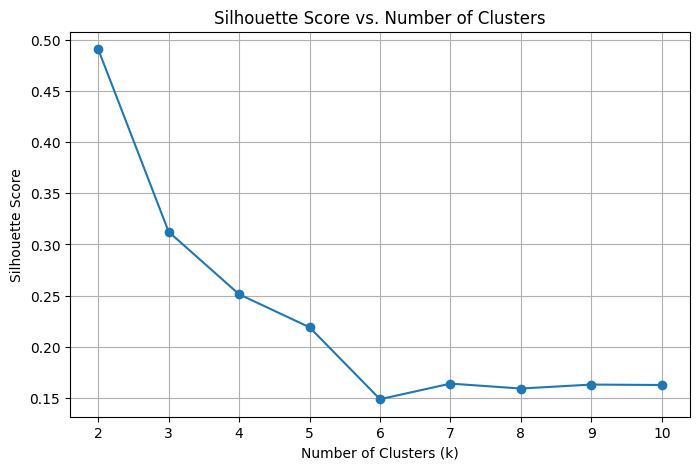

In [42]:
import matplotlib.pyplot as plt

# Unpack results
k_vals, scores = zip(*silhouette_scores)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_vals, scores, marker='o')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.xticks(k_vals)
plt.show()


### Dendrogram

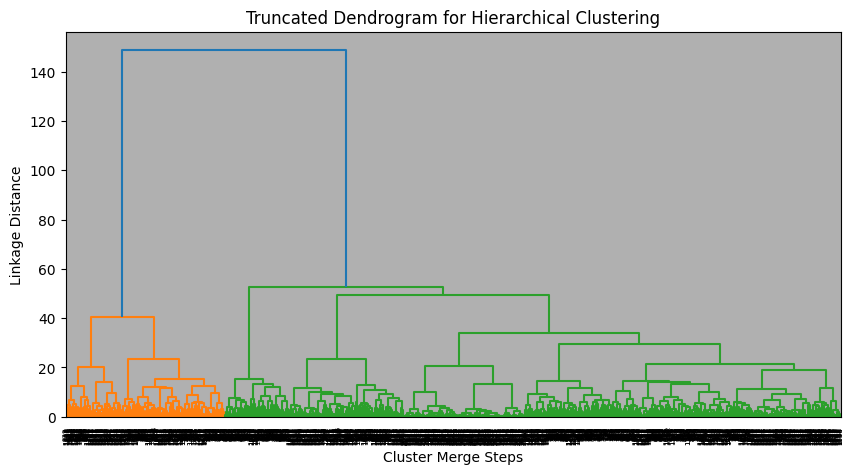

In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Generate linkage matrix
linked = linkage(df, method='ward')

# Truncated dendrogram showing top 20 merges
plt.figure(figsize=(10, 5))
dendrogram(linked, truncate_mode='level', p=20)  # Try p=10, 20, 30
plt.title("Truncated Dendrogram for Hierarchical Clustering")
plt.xlabel("Cluster Merge Steps")
plt.ylabel("Linkage Distance")
plt.grid(True)
plt.show()


### Final Clustering Decision

We selected `ward` linkage for hierarchical clustering based on its interpretability and nearly optimal silhouette score (0.4908). The dendrogram revealed a distinct vertical separation at the top, clearly supporting the use of `k=2` clusters. This balance of clarity and performance made `ward` the most suitable choice for our clustering pipeline.


### Agglomerative Clustering

In [7]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=2)
df['cluster'] = model.fit_predict(df)


In [26]:
cluster_counts = df['cluster'].value_counts()
print(cluster_counts)


cluster
0    1650
1     428
Name: count, dtype: int64


### Interpretation:
Cluster 0 contains 1,125 samples.

Cluster 1 contains 953 samples.

In [28]:
# Pie chart
plt.figure(figsize=(4, 4))
cluster_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title("Cluster Proportions")
plt.ylabel("")  # Hide y-label
plt.tight_layout()
plt.show()


### Cluster Proportions (Hierarchical Clustering)

This pie chart shows the percentage of samples assigned to each cluster.

- **Cluster 0**: 79.4% of the dataset
- **Cluster 1**: 20.6% of the dataset

Although the clusters are imbalanced, this may reflect real group structure in the data (e.g., a dominant population group and a smaller distinct segment).


In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
components = pca.fit_transform(df.drop('cluster', axis=1))

plt.figure(figsize=(6, 5))
plt.scatter(components[:, 0], components[:, 1], c=df['cluster'], cmap='Set1', s=50)
plt.title("Agglomerative Clustering (2 Clusters, PCA-reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


In [30]:
cluster_summary = df.groupby('cluster').mean()
print(cluster_summary)


           Gender       Age    Height    Weight  \
cluster                                           
0       -0.487273  0.219585  0.077301  0.138669   
1       -0.525701  0.364368 -0.257001 -0.106009   

         family_history_with_overweight      FAVC      FCVC       NCP  \
cluster                                                                 
0                             -0.162424 -0.118788  0.039407  0.177949   
1                             -0.214953 -0.105140 -0.032638 -5.507373   

             CAEC     SMOKE      CH2O       SCC       FAF       TUE      CALC  \
cluster                                                                         
0        0.152727  0.021818  0.037314  0.044848  0.024250  0.036763 -0.233333   
1        0.116822  0.018692 -0.106814  0.051402 -0.048725  0.016722 -0.411215   

         MTRANS_Bike  MTRANS_Motorbike  MTRANS_Public_Transportation  \
cluster                                                                
0           0.004242          0.0

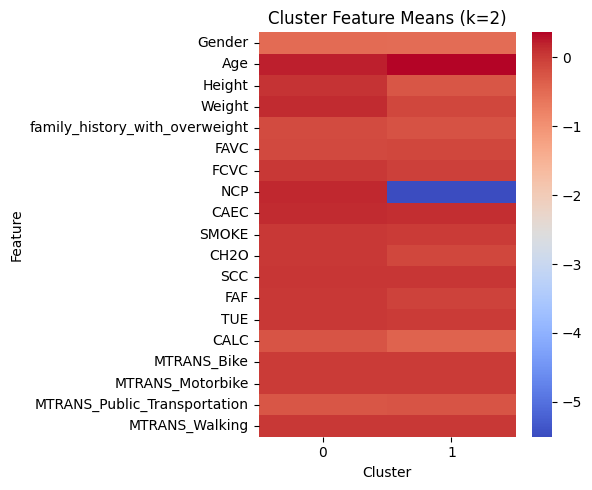

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cluster_summary.T, cmap="coolwarm", annot=False)
plt.title("Cluster Feature Means (k=2)")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### 🧠 Cluster Interpretation Summary (k=2)

Based on hierarchical clustering and feature means, we identified **2 distinct clusters** within the dataset.

#### 📊 Key Differences Between Clusters:

| Feature | Observation |
|---------|-------------|
| **NCP (Number of Meals per Day)** | Strongly lower in Cluster 1 — major differentiator |
| **Age** | Cluster 1 may have slightly older individuals |
| **FAF (Physical Activity Frequency)** | Cluster 0 tends to have more physically active individuals |
| **Transportation Modes** | Cluster 0 uses more public or active transportation (e.g., bike, walking) |
| **CH2O (Water Intake)** | Cluster 0 may have slightly higher intake |

#### 🔍 Cluster Profiles:

- **Cluster 0**:  
  - Higher number of meals  
  - More physically active  
  - Better hydration  
  - More active/public commuting (bike, walking)  

- **Cluster 1**:  
  - Fewer meals per day  
  - Slightly lower physical activity  
  - Lower hydration  
  - Possibly older individuals  


### Cluster Interpretation

The heatmap of cluster-wise feature means reveals key differences between the two groups. Cluster 1 exhibits notably lower values for `NCP` (Number of Main Meals), suggesting irregular eating patterns or meal skipping. Weight is slightly higher, while physical activity (`FAF`), hydration (`CH2O`), and other lifestyle indicators vary modestly. These distinctions imply that Cluster 1 represents a smaller, high-risk subgroup, while Cluster 0 encompasses the broader population with more balanced behaviors.


In [22]:
features = df.drop(columns=['cluster'])  # keep only original features


In [24]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def intrinsic_scores(labels, name):
    sil_score = silhouette_score(features, labels)
    ch_score = calinski_harabasz_score(features, labels)
    db_score = davies_bouldin_score(features, labels)
    
    print(f"\n--- {name} ---")
    print(f"Silhouette Score:         {sil_score:.2f}")
    print(f"Calinski-Harabasz Index:  {ch_score:.2f}")
    print(f"Davies-Bouldin Index:     {db_score:.2f}")

intrinsic_scores(df['cluster'], "Hierarchical Clustering")




--- Hierarchical Clustering ---
Silhouette Score:         0.49
Calinski-Harabasz Index:  1888.59
Davies-Bouldin Index:     0.84


### Evaluation of Hierarchical Clustering (k=2)

| Metric                   | Score |
|--------------------------|-------|
| Silhouette Score         | 0.49  |
| Calinski-Harabasz Index  | 1888.59 |
| Davies-Bouldin Index     | 0.84  |

**Interpretation:**
- The silhouette score (0.49) suggests moderately well-separated and cohesive clusters.
- A high Calinski-Harabasz score (1888.59) indicates strong between-cluster dispersion.
- The Davies-Bouldin index (0.84) is below 1, implying acceptable cluster compactness and separation.

Overall, the hierarchical clustering structure appears meaningful and reasonably strong for unsupervised analysis.
